In [11]:
import pandas as pd
import numpy as np
df = pd.read_csv("saved/5m_journal_conf_comp_sci_with_rank_features.csv")

In [12]:
df.columns.tolist()

['PaperId',
 'Abstract',
 'Author_1',
 'Author_10',
 'Author_11',
 'Author_2',
 'Author_3',
 'Author_4',
 'Author_5',
 'Author_6',
 'Author_7',
 'Author_8',
 'Author_9',
 'CitationCount',
 'CitationCountPerYear',
 'FieldOfStudy_0',
 'FieldOfStudy_1',
 'FieldOfStudy_2',
 'FieldOfStudy_3',
 'FieldOfStudy_4',
 'FieldOfStudy_5',
 'FirstPage',
 'JournalName',
 'LastPage',
 'PaperId.1',
 'PublishedDate',
 'Publisher',
 'Rank',
 'Title',
 'YearsSincePublication',
 'AuthorProminence',
 'MagBin',
 'CitationBin',
 'AuthorRank',
 'JournalNameRank',
 'PublisherRank']

In [13]:
df.shape

(282456, 36)

In [26]:
import spacy
nlp = spacy.load("en_core_web_sm")
STOPWORDS = nlp.Defaults.stop_words

In [34]:
df = df.assign(processed_abstract=preprocess_text_col(df["Abstract"]))

In [36]:
df.to_csv("saved/5m_conf_cs_preprocessed_text.csv")

# Load in preprocessed data

In [7]:
# Due to streamlit these need to be redefined here
def include_token(token):
    return (
        not token.is_punct
        and not token.like_num
        and token.lemma_ != "-PRON-"
        and token.lemma_ not in STOPWORDS
        and not token.is_space
    )

def preprocess_text_col(text_col):
    preproc_pipe = []
    for doc in nlp.pipe(
        text_col,
        batch_size=20,
        disable=["tagger", "parser", "entity", "ner", "textcat"],
    ):
        tokens = [token.lemma_ for token in doc if include_token(token)]
        preproc_pipe.append((" ".join(tokens).lower()))
    return preproc_pipe

def vectorize_text(df, text_col, vectorizer):
    vectorized = vectorizer.fit_transform(df[text_col])
    vectorized_df = pd.DataFrame.sparse.from_spmatrix(
        vectorized, columns=vectorizer.get_feature_names(), index=df.index
    )

    return vectorized_df, vectorizer

In [3]:
import pandas as pd
df = pd.read_csv("saved/5m_conf_cs_preprocessed_text.csv")

In [4]:
df.columns

Index(['Unnamed: 0', 'PaperId', 'Abstract', 'Author_1', 'Author_10',
       'Author_11', 'Author_2', 'Author_3', 'Author_4', 'Author_5', 'Author_6',
       'Author_7', 'Author_8', 'Author_9', 'CitationCount',
       'CitationCountPerYear', 'FieldOfStudy_0', 'FieldOfStudy_1',
       'FieldOfStudy_2', 'FieldOfStudy_3', 'FieldOfStudy_4', 'FieldOfStudy_5',
       'FirstPage', 'JournalName', 'LastPage', 'PaperId.1', 'PublishedDate',
       'Publisher', 'Rank', 'Title', 'YearsSincePublication',
       'AuthorProminence', 'MagBin', 'CitationBin', 'AuthorRank',
       'JournalNameRank', 'PublisherRank', 'processed_abstract'],
      dtype='object')

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
df_bow, vectorizer = vectorize_text(
        df, "processed_abstract", CountVectorizer(min_df=0.1)
    )

In [33]:
import umap
reducer = umap.UMAP()

In [34]:
embedding = reducer.fit_transform(df_bow.iloc[:5000])

Text(0.5, 1.0, 'UMAP projection Bag-of-Words')

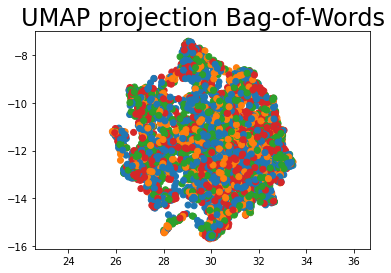

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in df.CitationBin[:5000].map({"low": 0, "below-average": 1, "above-average": 2, "high": 3})]
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection Bag-of-Words', fontsize=24)
